In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import re
from math import log
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.preprocessing import MultiLabelBinarizer
import statsmodels.api as sm

In [3]:
df_gemma_all = pd.read_json('result/segmentation_results__Gemma_mmlupro_en_en_processed.jsonl__Gemma_mmlupro_en_en_processed.jsonl', lines=True)
df_llama_all = pd.read_json('result/segmentation_results__Llama_mmlupro_en_en_processed.jsonl__Llama_mmlupro_en_en_processed.jsonl', lines=True)
df_qwen_all = pd.read_json('result/segmentation_results__Qwen_mmlupro_en_en_processed.jsonl__Qwen_mmlupro_en_en_processed.jsonl', lines=True)

In [ ]:
def extract_and_normalize_step_types(df: pd.DataFrame) -> pd.DataFrame:
    # TARGET_TYPES = ["subgoal setting", "backtracking", "verification", "backward chaining"]
    TARGET_TYPES = ["subgoal setting", "backtracking", "verification", "backward chaining"]
    def extract_response_text(response):
        # 自动处理字符串或 dict
        if isinstance(response, str):
            try:
                response = json.loads(response)
            except Exception:
                return ""

        try:
            return response['candidates'][0]['content']['parts'][0]['text']
        except Exception:
            return ""

    def extract_final_answer_block(text):
        match = re.search(r"\[Final answer\](.*)", text, re.DOTALL)
        return match.group(1).strip() if match else None

    def extract_step_labels(text):
        if not isinstance(text, str):
            return []
        return re.findall(r"<step_\d+>(.*?)</step_\d+>", text)

    def clean_label(label):
        return label.replace("<", "").replace(">", "").strip()

    def normalize_label(label):
        label_lower = label.lower()
        for target in TARGET_TYPES:
            if target in label_lower:
                return target
        return "other"

    # 复制原始数据
    df_out = df.copy()

    # 执行处理流程
    df_out['response_text'] = df_out['response'].apply(extract_response_text)
    df_out['final_answer_block'] = df_out['response_text'].apply(extract_final_answer_block)
    df_out['step_types'] = df_out['final_answer_block'].apply(extract_step_labels)
    df_out['step_types_clean'] = df_out['step_types'].apply(
        lambda labels: [clean_label(label) for label in labels]
    )
    df_out['step_types_normalized'] = df_out['step_types_clean'].apply(
        lambda labels: [normalize_label(label) for label in labels]
    )

    # 删除中间字段如有需要
    df_out.drop(columns=['response_text'], inplace=True)

    return df_out


In [4]:
df_gemma_all_simple = extract_and_normalize_step_types(df_gemma_all)
df_llama_all_simple = extract_and_normalize_step_types(df_llama_all)
df_qwen_all_simple = extract_and_normalize_step_types(df_qwen_all)

In [5]:
df_gemma_all['response_text'] = df_gemma_all['response'].apply(
    lambda r: r['candidates'][0]['content']['parts'][0]['text']
)

def extract_final_answer_block(text):
    match = re.search(r"\[Final answer\](.*)", text, re.DOTALL)
    return match.group(1).strip() if match else None

df_gemma_all['final_answer_block'] = df_gemma_all['response_text'].apply(extract_final_answer_block)
df_gemma_all_simple = df_gemma_all.drop(columns=['status', 'request', 'response_text', 'response', 'processed_time'])
def extract_step_labels(text):
    if not isinstance(text, str):
        return []
    return re.findall(r"<step_\d+>(.*?)</step_\d+>", text)
df_gemma_all_simple['step_types'] = df_gemma_all_simple['final_answer_block'].apply(extract_step_labels)

df_gemma_all_simple['step_types_clean'] = df_gemma_all_simple['step_types'].apply(
    lambda labels: [label.replace("<", "").replace(">", "") for label in labels]
)

TARGET_TYPES = ["subgoal setting", "backtracking", "verification", "backward chaining"]
def normalize_label(label):
    label_lower = label.lower()
    for target in TARGET_TYPES:
        if target in label_lower:
            return target  # 返回标准化类别
    return "other"  # 默认归类为 other

# 对每行的标签列表进行映射
df_gemma_all_simple['step_types_normalized'] = df_gemma_all_simple['step_types_clean'].apply(
    lambda labels: [normalize_label(label) for label in labels]
)


In [6]:
df_qwen_all_simple = df_qwen_all_simple.sort_values(by="id", ascending=True)
df_llama_all_simple = df_llama_all_simple.sort_values(by="id", ascending=True)
df_gemma_all_simple = df_gemma_all_simple.sort_values(by="id", ascending=True)

In [7]:
df_qwen_all_simple

,id,status,processed_time,request,response,final_answer_block,step_types,step_types_clean,step_types_normalized
49068,0,,2025-06-13 01:02:23.321000+00:00,{'contents': [{'parts': {'text': 'Here is a pr...,{'candidates': [{'avgLogprobs': -0.31575367947...,<step_1>Subgoal setting</step_1>\n<step_2>Subg...,"[Subgoal setting, Subgoal setting, Subgoal set...","[Subgoal setting, Subgoal setting, Subgoal set...","[subgoal setting, subgoal setting, subgoal set..."
48257,1,,2025-06-13 00:51:48.135000+00:00,{'contents': [{'parts': {'text': 'Here is a pr...,{'candidates': [{'avgLogprobs': -0.21235669633...,<step_1>Subgoal setting</step_1>\n<step_2>Othe...,"[Subgoal setting, Others, Others, Others, Othe...","[Subgoal setting, Others, Others, Others, Othe...","[subgoal setting, other, other, other, other, ..."
84893,2,,2025-06-13 00:52:45.470000+00:00,{'contents': [{'parts': {'text': 'Here is a pr...,{'candidates': [{'avgLogprobs': -0.18967428301...,<step_1>Others</step_1>\n<step_2>Subgoal setti...,"[Others, Subgoal setting, Others, Others]","[Others, Subgoal setting, Others, Others]","[other, subgoal setting, other, other]"
58606,3,,2025-06-13 01:02:13.710000+00:00,{'contents': [{'parts': {'text': 'Here is a pr...,{'candidates': [{'avgLogprobs': -0.42953176596...,<step_1><type_name_1>Subgoal setting</type_1><...,"[<type_name_1>Subgoal setting</type_1>, <type_...","[type_name_1Subgoal setting/type_1, type_name_...","[subgoal setting, subgoal setting, subgoal set..."
90858,4,,2025-06-13 00:51:43.008000+00:00,{'contents': [{'parts': {'text': 'Here is a pr...,{'candidates': [{'avgLogprobs': -0.45606206068...,<step_1>Subgoal setting</step_1>\n<step_2>Subg...,"[Subgoal setting, Subgoal setting, Others, Oth...","[Subgoal setting, Subgoal setting, Others, Oth...","[subgoal setting, subgoal setting, other, othe..."
...,...,...,...,...,...,...,...,...,...
48853,99995,,2025-06-13 00:55:29.611000+00:00,{'contents': [{'parts': {'text': 'Here is a pr...,{'candidates': [{'avgLogprobs': -0.26987882850...,<step_1>Subgoal setting</step_1>\n<step_2>Othe...,"[Subgoal setting, Others, Others, Others, Othe...","[Subgoal setting, Others, Others, Others, Othe...","[subgoal setting, other, other, other, other, ..."
14507,99996,,2025-06-13 00:59:56.848000+00:00,{'contents': [{'parts': {'text': 'Here is a pr...,{'candidates': [{'avgLogprobs': -0.42078610684...,<step_1>Others</step_1>\n<step_2>Others</step_...,"[Others, Others, Others, Others, Others, Other...","[Others, Others, Others, Others, Others, Other...","[other, other, other, other, other, other, other]"
24846,99997,,2025-06-13 00:55:38.844000+00:00,{'contents': [{'parts': {'text': 'Here is a pr...,{'candidates': [{'avgLogprobs': -0.22558450340...,<step_1>Subgoal setting</step_1>\n<step_2>Subg...,"[Subgoal setting, Subgoal setting, Others, Oth...","[Subgoal setting, Subgoal setting, Others, Oth...","[subgoal setting, subgoal setting, other, othe..."
7280,99998,,2025-06-13 01:04:22.200000+00:00,{'contents': [{'parts': {'text': 'Here is a pr...,{'candidates': [{'avgLogprobs': -0.31017017592...,<step_1>Subgoal setting</step_1>\n<step_2>Othe...,"[Subgoal setting, Others, Others, Subgoal sett...","[Subgoal setting, Others, Others, Subgoal sett...","[subgoal setting, other, other, subgoal settin..."


In [8]:
#全局统计
def get_label_counts(df):
    all_labels = [label for labels in df['step_types_normalized'] for label in labels]
    label_counts = Counter(all_labels)
    return pd.DataFrame(label_counts.items(), columns=["Label", "Count"]).sort_values(by="Count", ascending=False)

# 分别处理三个模型
df_gemma_counts = get_label_counts(df_gemma_all_simple)
df_llama_counts = get_label_counts(df_llama_all_simple)
df_qwen_counts = get_label_counts(df_qwen_all_simple)

# 如果想统一管理，也可以放在一个 dict 中
label_counts_dict = {
    "Gemma": df_gemma_counts,
    "LLaMA": df_llama_counts,
    "Qwen": df_qwen_counts
}

for model, df_counts in label_counts_dict.items():
    print(f"\n{model} label distribution:")
    print(df_counts)


Gemma label distribution:
               Label    Count
0              other  1055563
1    subgoal setting   184548
2       verification    22293
3       backtracking     9471
4  backward chaining     1771

LLaMA label distribution:
               Label    Count
1              other  1107023
0    subgoal setting   124813
4       backtracking    81917
2       verification    53782
3  backward chaining      886

Qwen label distribution:
               Label   Count
1              other  606496
0    subgoal setting  108810
3       verification   16137
2       backtracking    2521
4  backward chaining     616


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 合并并去除 "Other"
df_all_counts = []

for model, df_counts in label_counts_dict.items():
    df_filtered = df_counts[df_counts["Label"] != "other"].copy()
    df_filtered["Model"] = model
    df_all_counts.append(df_filtered)

df_all = pd.concat(df_all_counts, ignore_index=True)

# 绘图：x 是 model，y 是 count，hue 是 label
plt.figure(figsize=(12, 6))
sns.barplot(data=df_all, x="Model", y="Count", hue="Label")

# 美化
plt.title("Reasoning Step Distribution by Model")
plt.xlabel("Model")
plt.ylabel("Count")
plt.legend(title="Reasoning Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [6]:
df_gemma_output = pd.read_json('../../segmentation/exp3_data/Gemma_mmlupro_en_en_processed.jsonl', lines=True)
df_llama_output = pd.read_json('../../segmentation/exp3_data/Llama_mmlupro_en_en_processed.jsonl', lines=True)
df_qwen_output = pd.read_json('../../segmentation/exp3_data/Qwen_mmlupro_en_en_processed.jsonl', lines=True)

In [44]:
REASONING_TYPES = ["subgoal setting", "backtracking", "verification", "backward chaining"]

def get_behavior_and_acc_binned(df_behavior, df_output, bin_size=100):
    rows = []
    df_behavior = df_behavior.reset_index(drop=True)
    df_output = df_output.reset_index(drop=True)
    
    total = len(df_behavior)
    for i in range(0, total, bin_size):
        chunk_behavior = df_behavior.iloc[i:i+bin_size]
        chunk_output = df_output.iloc[i:i+bin_size]

        # 统计行为
        all_labels = [label for labels in chunk_behavior["step_types_normalized"] for label in labels]
        counter = Counter(all_labels)

        row = {
            "prompt_id": f"{i}_{min(i+bin_size-1, total-1)}",
        }
        reasoning_sum = 0
        for behavior in REASONING_TYPES:
            count = counter.get(behavior, 0)
            row[behavior] = count
            reasoning_sum += count
        
        row["reasoning_total"] = reasoning_sum
        row["other"] = sum(counter.values()) - reasoning_sum
        row["avgacc"] = chunk_output["is_correct"].mean()

        rows.append(row)
    return pd.DataFrame(rows)

df_gemma_bins = get_behavior_and_acc_binned(df_gemma_all_simple, df_gemma_output)
df_llama_bins = get_behavior_and_acc_binned(df_llama_all_simple, df_llama_output)
df_qwen_bins = get_behavior_and_acc_binned(df_qwen_all_simple, df_qwen_output)


In [45]:
df_gemma_bins

,prompt_id,subgoal setting,backtracking,verification,backward chaining,reasoning_total,other,avgacc
0,0_99,188,7,10,2,207,964,0.54
1,100_199,146,19,18,2,185,556,0.66
2,200_299,214,8,8,1,231,757,0.54
3,300_399,106,14,30,9,159,577,0.63
4,400_499,149,12,40,4,205,1430,0.54
...,...,...,...,...,...,...,...,...
995,99500_99599,396,2,8,0,406,1133,0.45
996,99600_99699,271,13,22,0,306,1673,0.55
997,99700_99799,155,3,13,1,172,672,0.50
998,99800_99899,145,5,21,0,171,1218,0.57


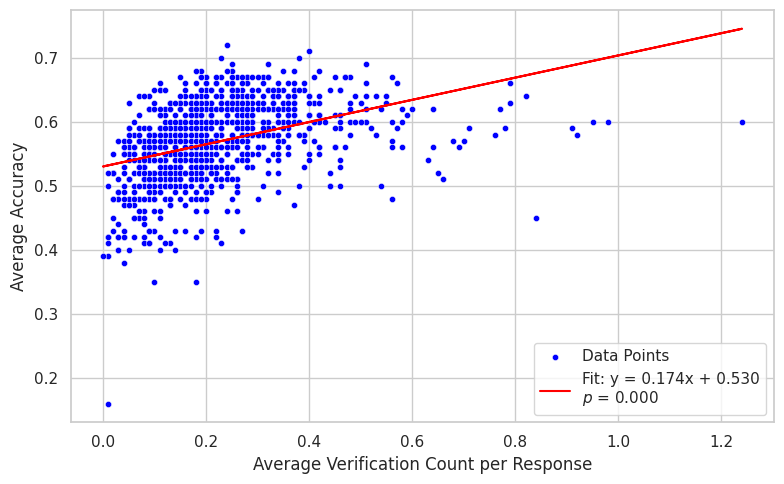

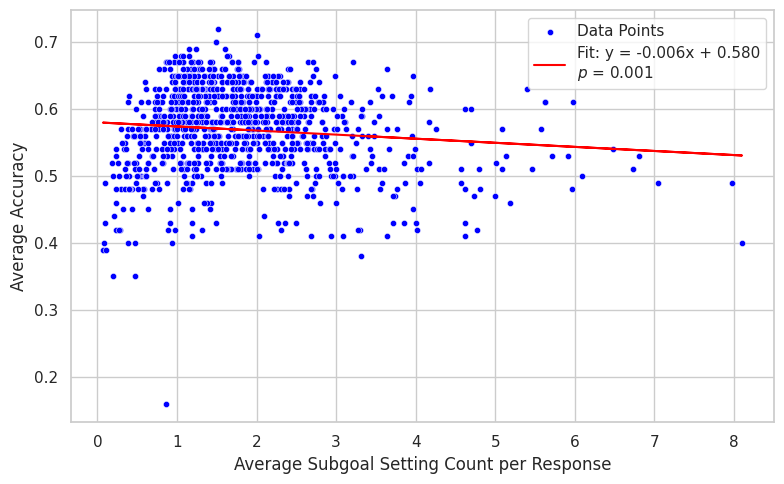

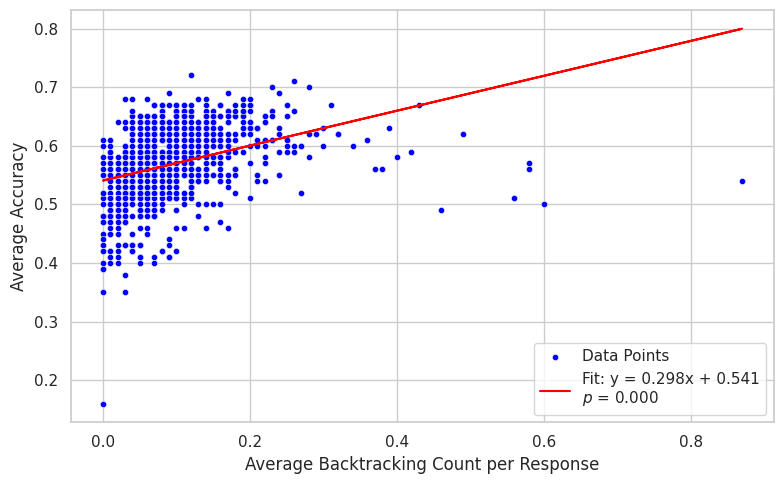

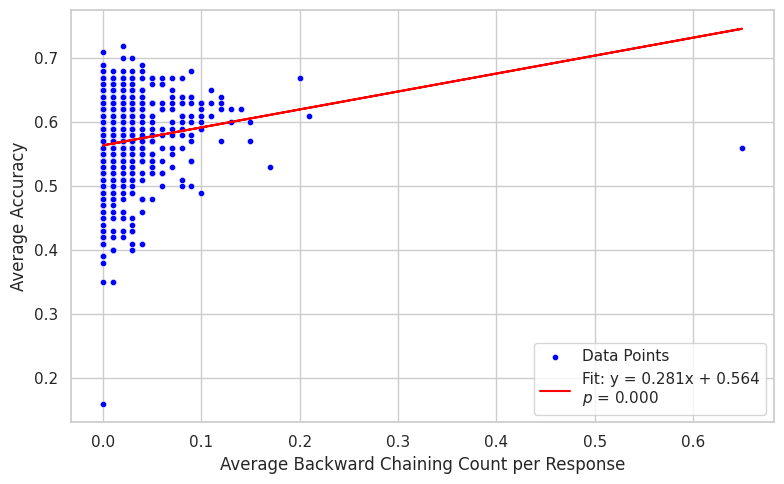

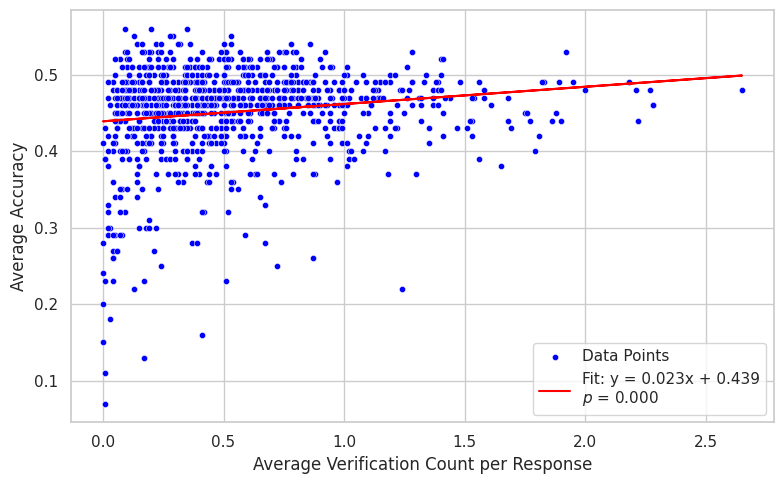

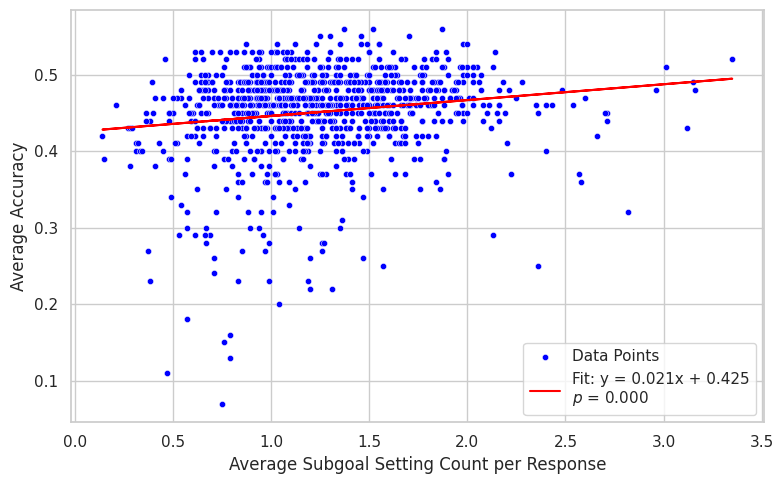

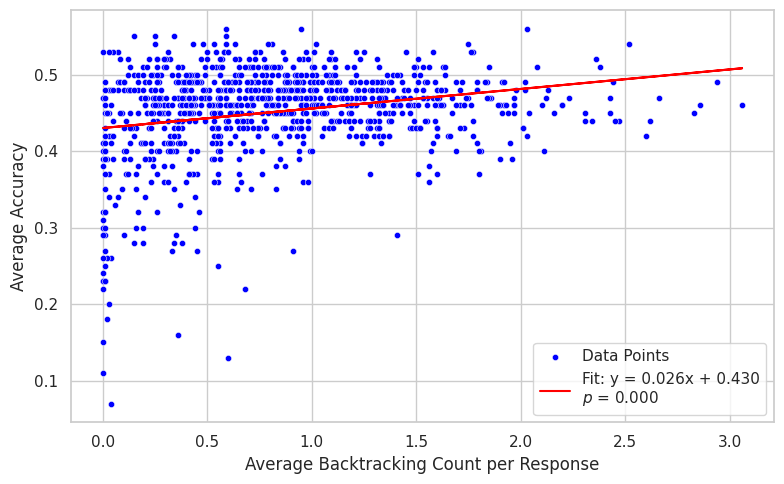

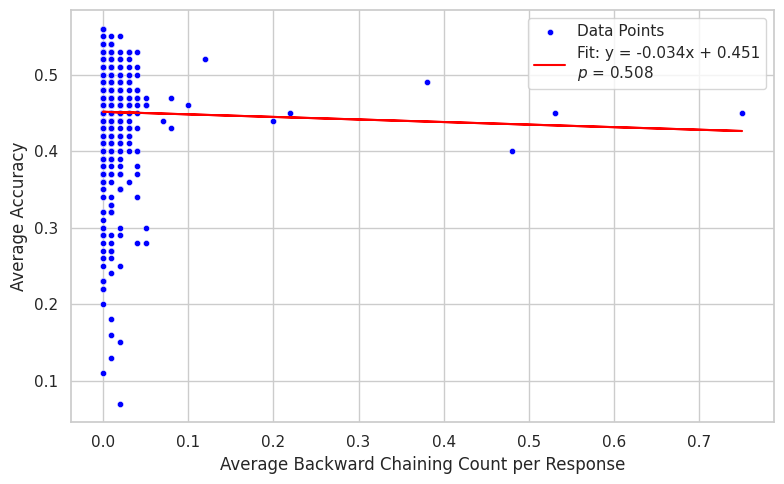

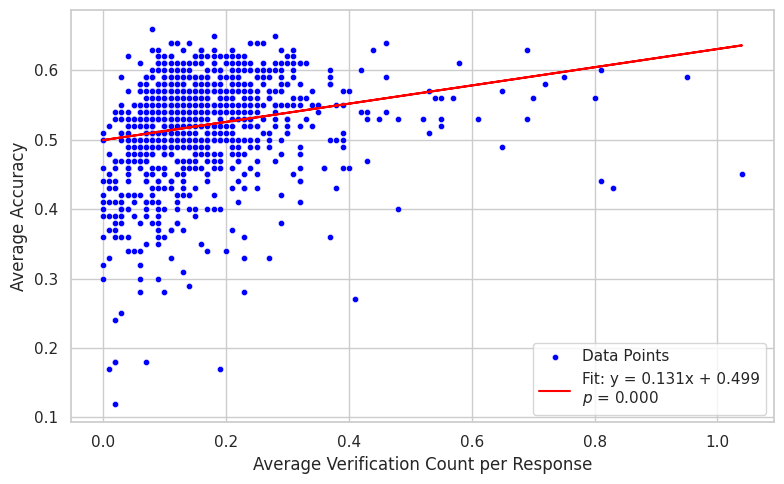

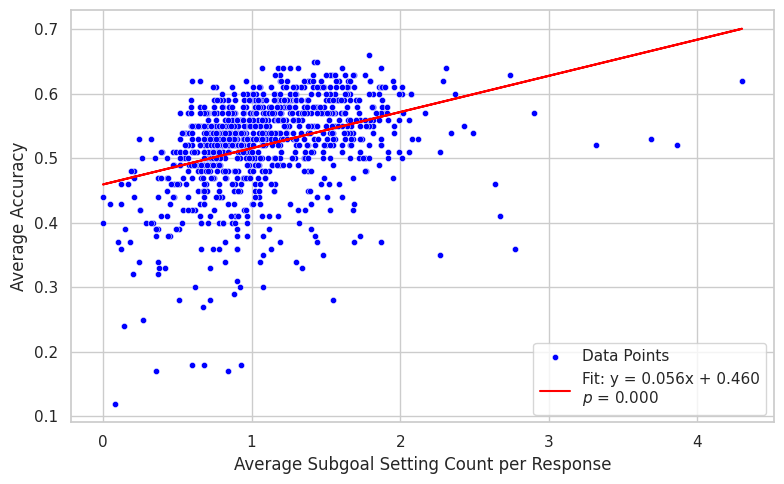

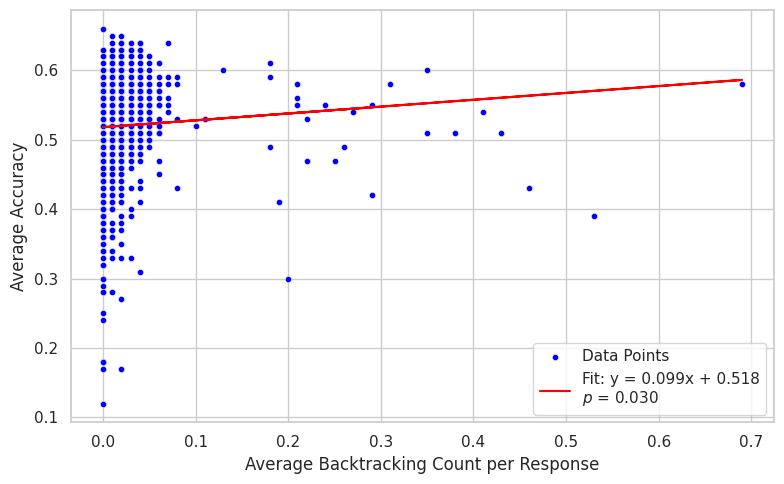

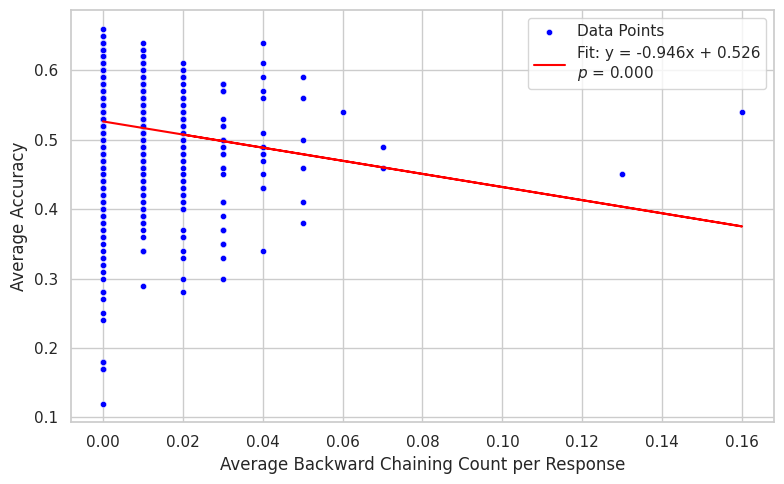

In [52]:
from scipy import stats
def plot_behavior_vs_acc(df, behavior_col):
    x = df[behavior_col] / 100
    y = df["avgacc"]

    slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
    regression_line = slope * x + intercept

    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=x, y=y, s=20, color="blue", label="Data Points")

    plt.plot(x, regression_line, color="red", label=f"Fit: y = {slope:.3f}x + {intercept:.3f}\n$p$ = {p_value:.3f}")

    # plt.title(f"Accuracy vs {behavior_col.title()} Count (per 100 prompts)")
    plt.xlabel(f"Average {behavior_col.title()} Count per Response")
    plt.ylabel("Average Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.show()

# 使用示例
plot_behavior_vs_acc(df_gemma_bins, "verification")
plot_behavior_vs_acc(df_gemma_bins, "subgoal setting")
plot_behavior_vs_acc(df_gemma_bins, "backtracking")
plot_behavior_vs_acc(df_gemma_bins, "backward chaining")

plot_behavior_vs_acc(df_llama_bins, "verification")
plot_behavior_vs_acc(df_llama_bins, "subgoal setting")
plot_behavior_vs_acc(df_llama_bins, "backtracking")
plot_behavior_vs_acc(df_llama_bins, "backward chaining")

plot_behavior_vs_acc(df_qwen_bins, "verification")
plot_behavior_vs_acc(df_qwen_bins, "subgoal setting")
plot_behavior_vs_acc(df_qwen_bins, "backtracking")
plot_behavior_vs_acc(df_qwen_bins, "backward chaining")


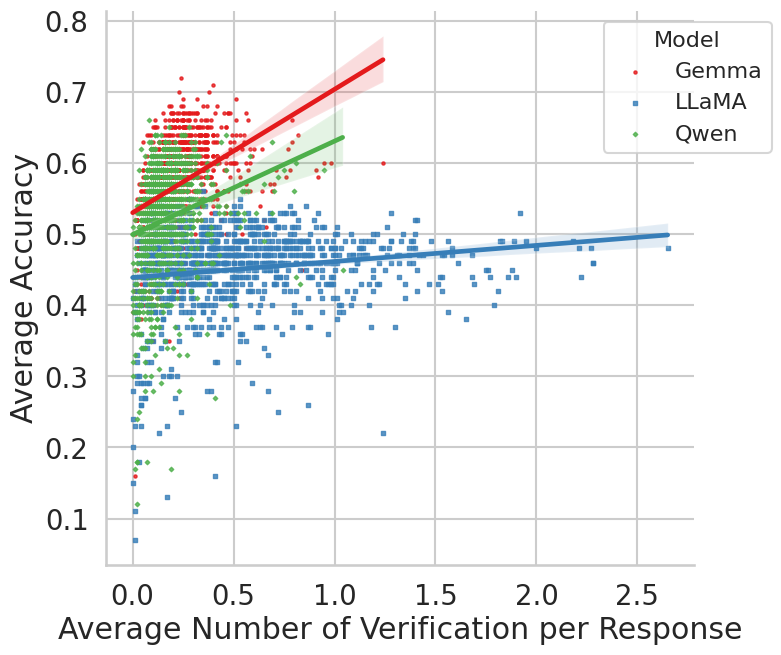

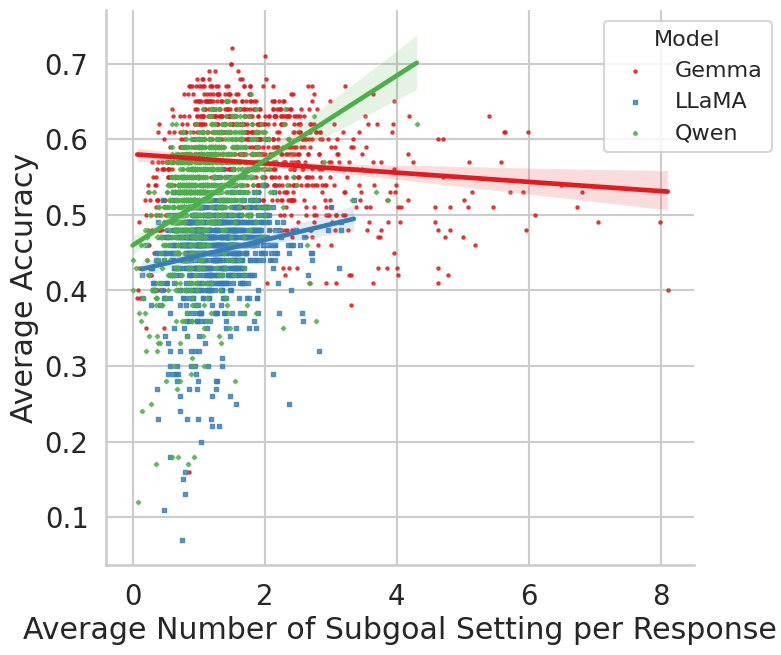

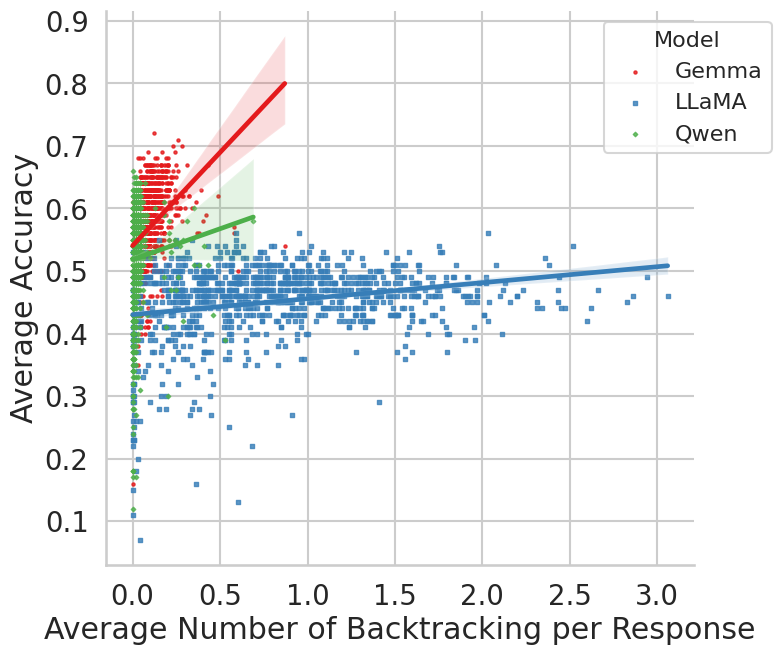

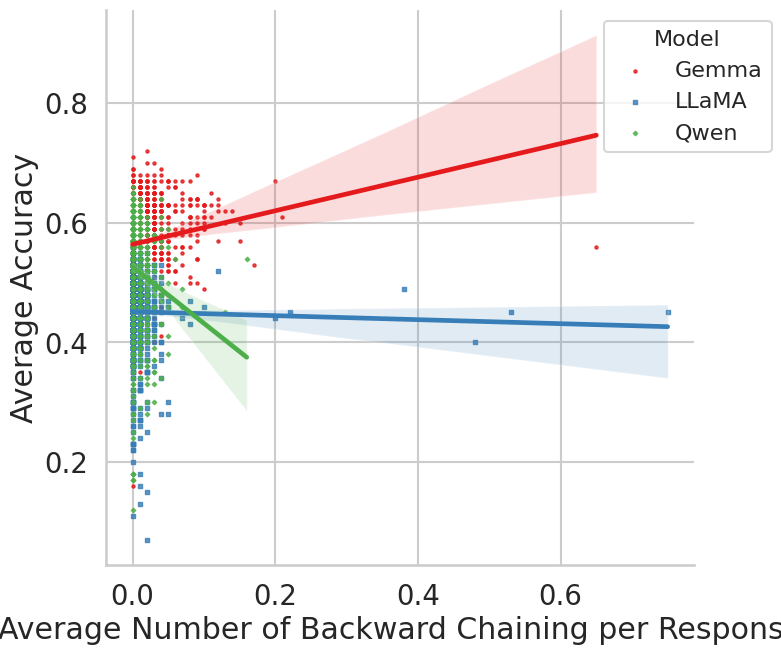

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

REASONING_TYPES = ["verification", "subgoal setting", "backtracking", "backward chaining"]

# 合并数据并添加 model 列
df_gemma_bins["model"] = "Gemma"
df_llama_bins["model"] = "LLaMA"
df_qwen_bins["model"] = "Qwen"

df_all = pd.concat([df_gemma_bins, df_llama_bins, df_qwen_bins], ignore_index=True)

# 设置全局字体大小
sns.set_context("talk", font_scale=1.2)  # 比默认大

# 为每种行为绘制一张图
for behavior in REASONING_TYPES:
    df_plot = df_all.copy()
    df_plot["count"] = df_plot[behavior] / 100

    g = sns.lmplot(
        data=df_plot,
        x="count",
        y="avgacc",
        hue="model",
        height=7,
        aspect=1.2,
        markers=["o", "s", "D"],
        palette="Set1",
        scatter_kws={"s": 5},  # 稍微调大一点点以适配字体
        legend=False  # 关闭默认 legend，手动添加
    )

    g.set_axis_labels(
        f"Average Number of {behavior.title()} per Response",
        "Average Accuracy"
    )

    # 设置 legend 手动位置：右上角外部
    plt.legend(
        title="Model",
        loc="upper right",
        bbox_to_anchor=(1.15, 1),
        fontsize=16,
        title_fontsize=16
    )

    # 可选添加标题
    # plt.title(f"Accuracy vs {behavior.title()} Count", fontsize=20)
    plt.tight_layout()
    plt.show()


In [31]:
df_qwen_bins

,prompt_id,subgoal setting,backtracking,verification,backward chaining,other,avgacc
0,0_99,131,29,18,0,514,0.42
1,100_199,65,5,8,0,300,0.49
2,200_299,102,3,8,0,498,0.50
3,300_399,82,2,70,0,348,0.56
4,400_499,154,1,18,0,768,0.58
...,...,...,...,...,...,...,...
995,99500_99599,71,0,17,1,636,0.40
996,99600_99699,208,0,45,0,770,0.53
997,99700_99799,36,0,1,0,2550,0.17
998,99800_99899,104,3,17,0,552,0.58


In [ ]:
#全局acc
dfs = [df_gemma_output, df_llama_output, df_qwen_output]
avgaccs = np.array([df["is_correct"].mean() for df in dfs])